In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as TF
from torchvision.transforms import transforms
import os
import cv2
import numpy as np
from typing import List, Dict, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from collections import defaultdict

# -----------------------------
# TridentNet Backbone
# -----------------------------
class TridentNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        # Use ResNet50 as base and modify for TridentNet-like behavior
        resnet = torchvision.models.resnet50(pretrained=True)
        
        # Freeze backbone weights
        for param in resnet.parameters():
            param.requires_grad = False
            
        # Extract layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Create dilated versions for TridentNet-like behavior
        self.dilated_conv1 = nn.Conv2d(2048, 512, 3, padding=1, dilation=1)
        self.dilated_conv2 = nn.Conv2d(2048, 512, 3, padding=2, dilation=2)
        self.dilated_conv3 = nn.Conv2d(2048, 512, 3, padding=4, dilation=4)
        
        # Make dilated convs trainable
        for param in [self.dilated_conv1.parameters(), 
                     self.dilated_conv2.parameters(), 
                     self.dilated_conv3.parameters()]:
            for p in param:
                p.requires_grad = True

    def forward(self, x):
        # Standard ResNet forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)  # [B, 2048, H/32, W/32]
        
        # Create 3 dilated feature maps
        feat1 = self.dilated_conv1(x)  # [B, 512, H/32, W/32]
        feat2 = self.dilated_conv2(x)  # [B, 512, H/32, W/32]
        feat3 = self.dilated_conv3(x)  # [B, 512, H/32, W/32]
        
        return [feat1, feat2, feat3]

# -----------------------------
# PANet Module
# -----------------------------
class PANetModule(nn.Module):
    def __init__(self, in_channels=512):
        super().__init__()
        # Freeze PANet-like operations (simulated)
        self.top_down_conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.bottom_up_conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.lateral_conv = nn.Conv2d(in_channels, 256, 1)
        self.fusion_conv = nn.Conv2d(256, 256, 3, padding=1)
        
        # Freeze PANet weights
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Simulate PANet processing
        lateral = self.lateral_conv(x)
        top_down = self.top_down_conv(x)
        bottom_up = self.bottom_up_conv(x)
        
        # Adaptive fusion pooling (simplified)
        fused = lateral + top_down + bottom_up
        output = self.fusion_conv(fused)
        
        return output

# -----------------------------
# Custom Backbone for Faster R-CNN
# -----------------------------
class CustomBackbone(nn.Module):
    def __init__(self, trident_net, pan_modules):
        super().__init__()
        self.trident_net = trident_net
        self.pan_modules = pan_modules
        self.out_channels = 256
        
        # Feature fusion layer (trainable)
        self.fusion_conv = nn.Conv2d(768, 256, 3, padding=1)  # 3*256 -> 256
        
    def forward(self, x):
        # Extract features from TridentNet
        trident_features = self.trident_net(x)
        
        # Pass through PANet modules
        pan_features = []
        for i, feat in enumerate(trident_features):
            pan_feat = self.pan_modules[i](feat)
            pan_features.append(pan_feat)
        
        # Concatenate and fuse features
        fused = torch.cat(pan_features, dim=1)  # [B, 768, H, W]
        output = self.fusion_conv(fused)  # [B, 256, H, W]
        
        return {"0": output}

# -----------------------------
# Complete Fusion Model
# -----------------------------
class FusionModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        # Initialize components
        self.trident_net = TridentNetBackbone()
        self.pan_modules = nn.ModuleList([
            PANetModule(in_channels=512),
            PANetModule(in_channels=512),
            PANetModule(in_channels=512)
        ])
        
        # Custom backbone for Faster R-CNN
        backbone = CustomBackbone(self.trident_net, self.pan_modules)
        
        # Anchor generator
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # ROI pooler
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        
        # Initialize Faster R-CNN
        self.faster_rcnn = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
        
        # Make Faster R-CNN head trainable (it's trainable by default)
        
    def forward(self, images, targets=None):
        return self.faster_rcnn(images, targets)

# -----------------------------
# Dataset Conversion
# -----------------------------
class YoloToDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, label_folder, transforms=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transforms = transforms
        self.images = [img for img in os.listdir(image_folder) 
                      if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])
        label_path = os.path.join(self.label_folder, 
                                 self.images[idx].rsplit('.', 1)[0] + '.txt')
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Load labels
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.strip()
                    if line:
                        parts = line.split()
                        cls = int(parts[0])
                        x, y, w, h = map(float, parts[1:5])
                        
                        # Convert YOLO format to Pascal VOC format
                        xmin = (x - w / 2) * width
                        ymin = (y - h / 2) * height
                        xmax = (x + w / 2) * width
                        ymax = (y + h / 2) * height
                        
                        # Ensure coordinates are within image bounds
                        xmin = max(0, min(xmin, width))
                        ymin = max(0, min(ymin, height))
                        xmax = max(0, min(xmax, width))
                        ymax = max(0, min(ymax, height))
                        
                        if xmax > xmin and ymax > ymin:  # Valid box
                            boxes.append([xmin, ymin, xmax, ymax])
                            labels.append(cls + 1)  # +1 because 0 is background
        
        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]  # Dummy box
            labels = [1]  # Dummy label
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, target

    def __len__(self):
        return len(self.images)

# -----------------------------
# Training Functions
# -----------------------------
def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, dataloader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_idx, (images, targets) in enumerate(dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {losses.item():.4f}')
    
    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch} Average Loss: {avg_loss:.4f}')
    return avg_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            
            # Get predictions
            predictions = model(images)
            
            all_predictions.extend(predictions)
            all_targets.extend(targets)
    
    return all_predictions, all_targets

# -----------------------------
# mAP Calculation
# -----------------------------
def calculate_map50(predictions, targets, num_classes=2, iou_threshold=0.5):
    """
    Calculate mAP@50 for object detection
    """
    # Convert to COCO format for evaluation
    coco_gt = {"images": [], "annotations": [], "categories": []}
    coco_dt = []
    
    # Add categories
    for i in range(1, num_classes):
        coco_gt["categories"].append({"id": i, "name": f"class_{i}"})
    
    ann_id = 0
    for img_id, (pred, target) in enumerate(zip(predictions, targets)):
        # Add image info
        coco_gt["images"].append({"id": img_id, "width": 640, "height": 640})
        
        # Add ground truth annotations
        for box, label in zip(target["boxes"], target["labels"]):
            x1, y1, x2, y2 = box.cpu().numpy()
            w, h = x2 - x1, y2 - y1
            coco_gt["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label.cpu().numpy()),
                "bbox": [float(x1), float(y1), float(w), float(h)],
                "area": float(w * h),
                "iscrowd": 0
            })
            ann_id += 1
        
        # Add predictions
        if len(pred["boxes"]) > 0:
            for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
                if score > 0.1:  # Confidence threshold
                    x1, y1, x2, y2 = box.cpu().numpy()
                    w, h = x2 - x1, y2 - y1
                    coco_dt.append({
                        "image_id": img_id,
                        "category_id": int(label.cpu().numpy()),
                        "bbox": [float(x1), float(y1), float(w), float(h)],
                        "score": float(score.cpu().numpy())
                    })
    
    # Create temporary files for COCO evaluation
    with open('temp_gt.json', 'w') as f:
        json.dump(coco_gt, f)
    
    # Load COCO ground truth
    coco_gt_obj = COCO('temp_gt.json')
    
    if len(coco_dt) > 0:
        coco_dt_obj = coco_gt_obj.loadRes(coco_dt)
        coco_eval = COCOeval(coco_gt_obj, coco_dt_obj, 'bbox')
        coco_eval.params.iouThrs = [iou_threshold]  # mAP@50
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        map50 = coco_eval.stats[0]
    else:
        map50 = 0.0
    
    # Clean up
    os.remove('temp_gt.json')
    
    return map50

# -----------------------------
# Visualization
# -----------------------------
def visualize_predictions(model, dataset, device, num_images=5, save_dir='visualizations'):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        for i in range(min(num_images, len(dataset))):
            image, target = dataset[i]
            
            # Get prediction
            pred = model([image.to(device)])[0]
            
            # Convert image to numpy
            img_np = image.permute(1, 2, 0).cpu().numpy()
            
            # Create subplot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
            
            # Plot ground truth
            ax1.imshow(img_np)
            ax1.set_title('Ground Truth')
            for box, label in zip(target['boxes'], target['labels']):
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       linewidth=2, edgecolor='red', facecolor='none')
                ax1.add_patch(rect)
                ax1.text(x1, y1-5, f'GT: {int(label)}', color='red', fontsize=10)
            
            # Plot predictions
            ax2.imshow(img_np)
            ax2.set_title('Predictions')
            for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
                if score > 0.5:  # Confidence threshold
                    x1, y1, x2, y2 = box.cpu().numpy()
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                           linewidth=2, edgecolor='blue', facecolor='none')
                    ax2.add_patch(rect)
                    ax2.text(x1, y1-5, f'Pred: {int(label)} ({score:.2f})', 
                            color='blue', fontsize=10)
            
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f'prediction_{i}.png'))
            plt.close()

# -----------------------------
# Main Training Script
# -----------------------------
def main():
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Data transforms
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = YoloToDetectionDataset(
        "/kaggle/input/traffic-2/traffic_wala_dataset/train/images",
        "/kaggle/input/traffic-2/traffic_wala_dataset/train/labels",
        transforms=train_transforms
    )
    
    val_dataset = YoloToDetectionDataset(
        "/kaggle/input/traffic-2/traffic_wala_dataset/valid/images",
        "/kaggle/input/traffic-2/traffic_wala_dataset/valid/labels",
        transforms=val_transforms
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=4, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=4, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Initialize model
    model = FusionModel(num_classes=2).to(device)
    
    # Optimizer (only for trainable parameters)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=1e-4,
        weight_decay=1e-4
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Training loop
    num_epochs = 50
    best_map = 0.0
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
        
        # Validate every 5 epochs
        if epoch % 5 == 0:
            print(f"Evaluating at epoch {epoch}...")
            predictions, targets = evaluate_model(model, val_loader, device)
            
            # Calculate mAP@50
            map50 = calculate_map50(predictions, targets)
            print(f"Epoch {epoch} - mAP@50: {map50:.4f}")
            
            # Save best model
            if map50 > best_map:
                best_map = map50
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'map50': map50,
                }, 'best_fusion_model.pth')
                print(f"New best model saved with mAP@50: {best_map:.4f}")
        
        scheduler.step()
    
    # Final evaluation
    print("Final evaluation...")
    model.load_state_dict(torch.load('best_fusion_model.pth')['model_state_dict'])
    predictions, targets = evaluate_model(model, val_loader, device)
    final_map = calculate_map50(predictions, targets)
    print(f"Final mAP@50: {final_map:.4f}")
    
    # Visualize predictions
    print("Creating visualizations...")
    visualize_predictions(model, val_dataset, device, num_images=10)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

Using device: cpu
Model loaded successfully!

Processing: 8_mp4-6_jpg.rf.9eddb296d3861c6af62c2d2c3ca30fb2.jpg


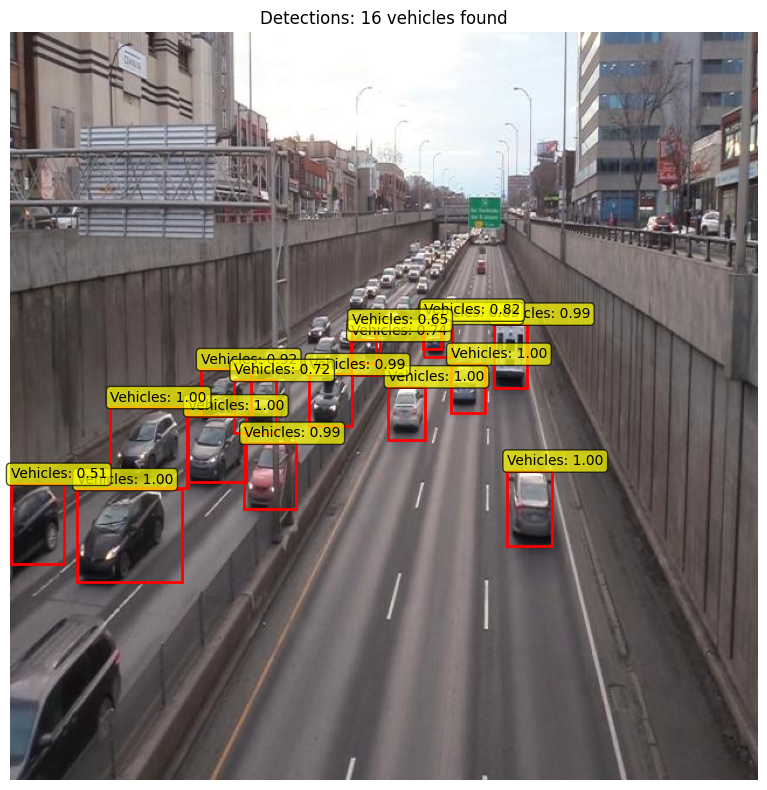

Found 16 detections:
Detection 1: Confidence 1.000, Box: [323.4, 302.8, 354.5, 348.5]
Detection 2: Confidence 1.000, Box: [425.0, 374.9, 463.6, 438.9]
Detection 3: Confidence 1.000, Box: [56.8, 390.8, 146.8, 470.3]
Detection 4: Confidence 0.999, Box: [151.6, 327.6, 201.7, 384.5]
Detection 5: Confidence 0.998, Box: [376.8, 283.5, 406.0, 325.2]
Detection 6: Confidence 0.998, Box: [85.5, 320.6, 150.8, 389.1]
Detection 7: Confidence 0.995, Box: [199.7, 351.1, 244.3, 407.5]
Detection 8: Confidence 0.995, Box: [413.4, 249.2, 442.3, 303.6]
Detection 9: Confidence 0.985, Box: [255.8, 292.3, 291.9, 336.6]
Detection 10: Confidence 0.923, Box: [162.6, 288.1, 206.0, 327.8]
Detection 11: Confidence 0.886, Box: [352.8, 248.5, 368.6, 270.8]
Detection 12: Confidence 0.821, Box: [353.9, 245.7, 377.6, 277.4]
Detection 13: Confidence 0.741, Box: [291.2, 263.2, 315.9, 292.8]
Detection 14: Confidence 0.719, Box: [191.2, 297.4, 227.2, 342.5]
Detection 15: Confidence 0.647, Box: [292.2, 254.4, 312.9, 282.2]


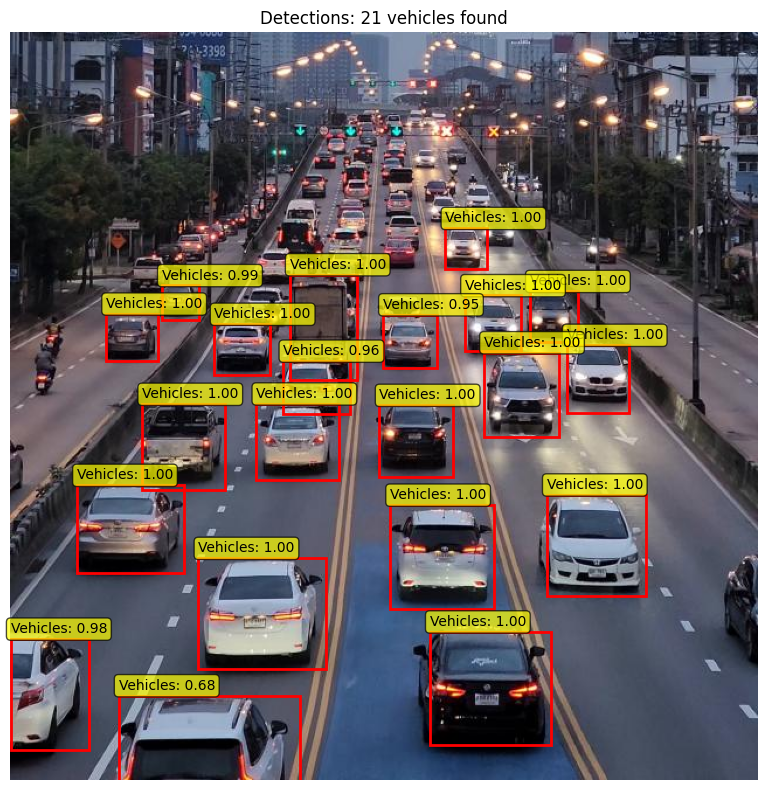

Found 21 detections:
Detection 1: Confidence 1.000, Box: [174.5, 249.3, 221.9, 293.1]
Detection 2: Confidence 1.000, Box: [56.7, 387.1, 148.1, 462.1]
Detection 3: Confidence 1.000, Box: [475.9, 267.3, 529.4, 325.3]
Detection 4: Confidence 1.000, Box: [324.7, 404.1, 413.5, 493.3]
Detection 5: Confidence 1.000, Box: [112.6, 317.8, 183.6, 391.2]
Detection 6: Confidence 1.000, Box: [458.9, 395.4, 543.9, 482.2]
Detection 7: Confidence 1.000, Box: [444.4, 221.2, 485.4, 264.8]
Detection 8: Confidence 1.000, Box: [358.7, 512.6, 462.8, 609.5]
Detection 9: Confidence 1.000, Box: [210.2, 317.5, 280.7, 382.5]
Detection 10: Confidence 1.000, Box: [81.6, 240.5, 125.9, 281.1]
Detection 11: Confidence 0.999, Box: [315.8, 318.7, 378.8, 380.4]
Detection 12: Confidence 0.999, Box: [388.8, 224.8, 437.0, 272.5]
Detection 13: Confidence 0.999, Box: [405.1, 273.6, 469.7, 346.2]
Detection 14: Confidence 0.999, Box: [160.7, 449.7, 269.9, 544.6]
Detection 15: Confidence 0.999, Box: [238.8, 206.9, 296.1, 297.2]


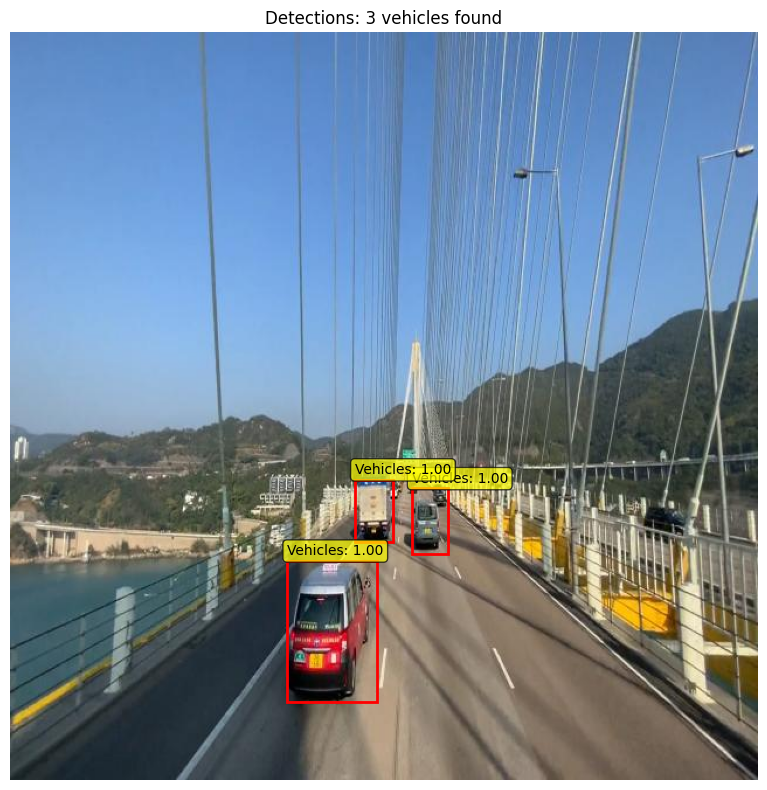

Found 3 detections:
Detection 1: Confidence 1.000, Box: [236.7, 451.9, 313.6, 573.0]
Detection 2: Confidence 0.999, Box: [343.2, 389.9, 374.5, 446.0]
Detection 3: Confidence 0.997, Box: [294.6, 382.5, 327.0, 435.6]


In [9]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2

# -----------------------------
# Model Architecture (Same as your original)
# -----------------------------
class TridentNetBackbone(nn.Module):
    def __init__(self, freeze_backbone=False):
        super().__init__()
        resnet = torchvision.models.resnet50(pretrained=False)
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.dilated_conv1 = nn.Conv2d(2048, 512, 3, padding=1, dilation=1)
        self.dilated_conv2 = nn.Conv2d(2048, 512, 3, padding=2, dilation=2)
        self.dilated_conv3 = nn.Conv2d(2048, 512, 3, padding=4, dilation=4)

        if freeze_backbone:
            for param in resnet.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        feat1 = self.dilated_conv1(x)
        feat2 = self.dilated_conv2(x)
        feat3 = self.dilated_conv3(x)
        
        return [feat1, feat2, feat3]

class PANetModule(nn.Module):
    def __init__(self, in_channels=512, freeze_panet=False):
        super().__init__()
        self.top_down_conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.bottom_up_conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.lateral_conv = nn.Conv2d(in_channels, 256, 1)
        self.fusion_conv = nn.Conv2d(256, 256, 3, padding=1)
        
        if freeze_panet:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        lateral = self.lateral_conv(x)
        top_down = self.top_down_conv(x)
        bottom_up = self.bottom_up_conv(x)
        
        fused = lateral + top_down + bottom_up
        output = self.fusion_conv(fused)
        
        return output

class CustomBackbone(nn.Module):
    def __init__(self, trident_net, pan_modules):
        super().__init__()
        self.trident_net = trident_net
        self.pan_modules = pan_modules
        self.out_channels = 256
        
        self.fusion_conv = nn.Conv2d(768, 256, 3, padding=1)
        
    def forward(self, x):
        trident_features = self.trident_net(x)
        
        pan_features = []
        for i, feat in enumerate(trident_features):
            pan_feat = self.pan_modules[i](feat)
            pan_features.append(pan_feat)
        
        fused = torch.cat(pan_features, dim=1)
        output = self.fusion_conv(fused)
        
        return {"0": output}

class FusionModel(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=False, freeze_panet=False):
        super().__init__()
        
        self.trident_net = TridentNetBackbone(freeze_backbone=freeze_backbone)
        self.pan_modules = nn.ModuleList([
            PANetModule(in_channels=512, freeze_panet=freeze_panet),
            PANetModule(in_channels=512, freeze_panet=freeze_panet),
            PANetModule(in_channels=512, freeze_panet=freeze_panet)
        ])
        
        backbone = CustomBackbone(self.trident_net, self.pan_modules)
        
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        
        self.faster_rcnn = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
        
    def forward(self, images, targets=None):
        return self.faster_rcnn(images, targets)

# -----------------------------
# Simple Inference Class
# -----------------------------
class SimpleInference:
    def __init__(self, model_path, device=None):
        """
        Simple initialization - just provide the model path
        """
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load model
        self.model = FusionModel(num_classes=2, freeze_backbone=False, freeze_panet=False)
        self.model.to(self.device)
        
        # Load weights (fix for PyTorch 2.6+ weights_only issue)
        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        else:
            self.model.load_state_dict(checkpoint, strict=False)
        
        self.model.eval()
        
        # Disable gradients for inference
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print("Model loaded successfully!")
    
    def predict_and_show(self, image_path, confidence=0.5):
        """
        Predict and visualize results in one simple function
        """
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).to(self.device)
        
        # Predict
        with torch.no_grad():
            predictions = self.model([image_tensor])[0]
        
        # Filter by confidence
        keep = predictions['scores'] > confidence
        boxes = predictions['boxes'][keep].cpu().numpy()
        scores = predictions['scores'][keep].cpu().numpy()
        labels = predictions['labels'][keep].cpu().numpy()
        
        # Visualize
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        
        ax = plt.gca()
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            
            # Draw bounding box
            rect = patches.Rectangle((x1, y1), width, height, 
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            
            # Add label
            plt.text(x1, y1 - 5, f'Vehicles: {score:.2f}', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                    fontsize=10, color='black')
        
        plt.title(f'Detections: {len(boxes)} vehicles found')
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"Found {len(boxes)} detections:")
        for i, (box, score) in enumerate(zip(boxes, scores)):
            print(f"Detection {i+1}: Confidence {score:.3f}, Box: [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]")
    

    def predict_on_video(self, video_path, confidence=0.5, output_path=None, display=True):
        cap = cv2.VideoCapture(video_path)
        
        # Define writer if output path is specified
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(
                output_path,
                fourcc,
                int(cap.get(cv2.CAP_PROP_FPS)),
                (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            )
        else:
            out = None

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB PIL image
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            image_tensor = self.transform(image).to(self.device)

            with torch.no_grad():
                predictions = self.model([image_tensor])[0]

            keep = predictions['scores'] > confidence
            boxes = predictions['boxes'][keep].cpu().numpy()
            scores = predictions['scores'][keep].cpu().numpy()
            labels = predictions['labels'][keep].cpu().numpy()

            # Draw predictions on the frame
            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = box.astype(int)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(frame, f"Vehicle: {score:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

            if display:
                cv2.imshow("Detections", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if out:
                out.write(frame)

        cap.release()
        if out:
            out.release()
        if display:
            cv2.destroyAllWindows()

# -----------------------------
# Usage Examples
# -----------------------------

# Example 1: Single image inference
def run_single_inference():
    # Initialize model (change path to your model)
    model_path = "best_fusion_model.pth"
    inference = SimpleInference(model_path)
    
    # Run inference on single image (change to your image path)
    image_path = r"traffic_wala_dataset\valid\images\test2_mp4-19_jpg.rf.a3723816acc8bacb1350cc05fb78b924.jpg"
    inference.predict_and_show(image_path, confidence=0.5)

# Example 2: Multiple images
def run_multiple_inference():
    # Initialize model
    model_path = "best_fusion_model.pth"
    inference = SimpleInference(model_path)
    
    # List of images to process
    image_paths = [
        r"traffic_wala_dataset\valid\images\8_mp4-6_jpg.rf.9eddb296d3861c6af62c2d2c3ca30fb2.jpg",
        r"traffic_wala_dataset\valid\images\5_mp4-5_jpg.rf.47c7656c79a6cfa7dbabfcaaeef94dea.jpg",
        r"traffic_wala_dataset\valid\images\6_mp4-1_jpg.rf.a30955a1b5b2a8db39354221db4f5b5f.jpg"
    ]
    
    # Process each image
    for img_path in image_paths:
        print(f"\nProcessing: {os.path.basename(img_path)}")
        inference.predict_and_show(img_path, confidence=0.5)

def run_video_inference():
    model_path = "best_fusion_model.pth"
    video_path = r"extracted_folder\traffic.mp4"
    output_path = "output_video.mp4"  # Optional output save path

    inference = SimpleInference(model_path)
    inference.predict_on_video(video_path, confidence=0.5, output_path=output_path, display=True)
# -----------------------------
# Main execution
# -----------------------------
if __name__ == "__main__":
    
    
   
    run_multiple_inference()
    # run_multiple_inference()